# 1. N-Gram

# (a) Use n = 2 and n = 3 to calculate bigrams and trigrams, respectively, and evaluate  the test accuracy in test.txt and make some discussion. (10%)

In [61]:
from collections import Counter, defaultdict, namedtuple
from tqdm import tqdm

In [9]:
# 建立Vocabulary
def build_vocabulary(file_path, min_frequency=5):
    vocabulary = defaultdict(lambda: len(vocabulary))
    word_counts = Counter()
    
    # 計算字出現的次數
    with open(file_path, 'r') as f:
        for line in f:
            tokens = line.strip().split()
            word_counts.update(tokens)
    
    # 加入<UNK>
    vocabulary["UNK"]
    
    # 設定門檻來過濾出現頻率太少的字
    for word, count in word_counts.items():
        if count >= min_frequency:
            vocabulary[word]
    
    print("Vocabulary size (including UNK):", len(vocabulary))
    return vocabulary

def replace_low_freq_words(tokens, vocabulary):
    return [token if token in vocabulary else "UNK" for token in tokens]

In [62]:
class NgramModel:
    def __init__(self, n):
        self.n = n
        self.total_grams = Counter()  
        self.word_counts = Counter()   
        self.ngram_prediction = defaultdict(set) 
        self.Word = namedtuple('Word', ['word', 'prob'])  

    def train(self, file_path):
        with open(file_path, "r") as d:
            sentences = d.readlines()
        
        for sentence in sentences:
            sentence = sentence.strip().split()
            split_words = list(sentence)
            
            for i in range(len(split_words) - self.n + 1):
                ngram = tuple(split_words[i:i + self.n])
                self.total_grams[ngram] += 1
            
            for i in range(len(split_words) - self.n + 2):
                word = tuple(split_words[i:i + self.n - 1])
                self.word_counts[word] += 1
        
        for key in self.total_grams:
            word = ' '.join(key[:-1])  
            next_word = key[-1]
            next_word_prob = self.total_grams[key] / self.word_counts[key[:-1]] if self.word_counts[key[:-1]] > 0 else 0
            
            w = self.Word(next_word, '{:.3g}'.format(next_word_prob))
            self.ngram_prediction[word].add(w)

    def prediction(self, context):
        previous_words = tuple(context.split()[-(self.n - 1):])  # 取得最後 (n-1) 個單字
        candidates = self.ngram_prediction.get(' '.join(previous_words), None)

        
        if not candidates:
            return None
        
        # 找到機率最大的candidate
        return max(candidates, key=lambda x: float(x.prob)).word

Testing

In [63]:
def testing(test_data, n):
    with open(test_data, "r") as d:
        test_sentences = d.readlines() # list

    correct_pred = 0
    total_pred = 0

    for sentence in tqdm(test_sentences):
        tokens = sentence.strip().split()
        
        if len(tokens) < n:  #句子長度小於n就跳過
            continue
        
        for i in range(len(tokens) - n + 1):
            n_minus_one_gram = tokens[i:i + n - 1]
            true_next_word = tokens[i + n -1]

            predicted_next_word = model.prediction(" ".join(n_minus_one_gram))

            if predicted_next_word == true_next_word:
                correct_pred += 1
            
            total_pred += 1
    

    accuracy = correct_pred / total_pred if total_pred > 0 else 0
    return accuracy

## n=2

In [64]:
file_path = "/kaggle/input/llm-hw1-dataset/train.txt"

model = NgramModel(n=2)
model.train(file_path)

In [65]:
test_data = "/kaggle/input/llm-hw1-dataset/test.txt"
accuracy = testing(test_data, n = 2)
print(f"Accuracy: {accuracy * 100:.2f}%")

100%|██████████| 649918/649918 [57:15<00:00, 189.16it/s] 

Accuracy: 25.79%


以CPU執行Bigram模型約一個小時半，GPU則是快一小時，準確率為25.79%。

## n=3

In [8]:
file_path = "/kaggle/input/llm-hw1-dataset/train.txt"

trigram_model = NgramModel(n=3)
trigram_model.train(file_path)

In [17]:
test_data = "/kaggle/input/llm-hw1-dataset/test.txt"
accuracy = testing(test_data, n = 3)
print(f"Accuracy: {accuracy * 100:.2f}%")

100%|██████████| 649918/649918 [1:28:22<00:00, 122.56it/s]

Accuracy: 24.65%


Trigram模型的執行時間也大約一個小時半，準確率為24.65%，比bigrama模型稍低一些。

# (b)  Please observe the hardware usage in your computer while the models are running, and make some discussion. (5%)

在執行n-gram模型時，CPU的使用率一直都處在100%，有時候還會到101%，原因可能在於n-gram模型要不斷地去計算n-gram的種類還有出現的頻率，並且計算條件機率，這些都會導致CPU使用率處在很高的狀態。

# (c) Please use the test sentences from incomplete.txt to evaluate the model. This test set contains some incomplete sentences. Use the trained trigram model to complete the sentences (to reach a length of 20 words). (5%)

In [12]:
def complete_sentences(trigram_model, incomplete_file, max_length=20):
    with open(incomplete_file, "r") as f:
        incomplete_sentences = f.readlines()

    completed_sentences = []

    for sentence in incomplete_sentences:
        tokens = sentence.strip().split()
        
        # 產生字直到超過最大長度為止
        while len(tokens) < max_length:
            
            # 用最後兩個字當成下一個預測的來源
            context = tokens[-2:]
            
            # 預測下一個字
            predicted_next_word = trigram_model.prediction(" ".join(context))
            
            # 沒有預測字就停止
            if predicted_next_word is None:
                break

            # 將預測好的字接在句子上
            tokens.append(predicted_next_word)

        completed_sentences.append(" ".join(tokens))

    # 輸出預測的句子
    for i, sentence in enumerate(completed_sentences):
        print(f"Completed Sentence {i+1}: {sentence}")

incomplete_file = "/kaggle/input/llm-hw1-dataset/incomplete.txt"
complete_sentences(trigram_model, incomplete_file, max_length=20)

Completed Sentence 1: cover with foil and bake for about 5 minutes or until the mixture into the pan and bake for about
Completed Sentence 2: roll up and place in a large bowl and mix well and set aside to cool completely on wire rack
Completed Sentence 3: cook the pasta and cook for about 5 minutes or until the mixture into the pan and bake for about
Completed Sentence 4: stir in the center of the pan and bake for about 5 minutes or until the mixture into the pan
Completed Sentence 5: spread out on a baking sheet and bake for about 5 minutes or until the mixture into the pan and
Completed Sentence 6: transfer the mixture into the pan and bake for about 5 minutes or until the mixture into the pan and
Completed Sentence 7: put the chicken and cook for about 5 minutes or until the mixture into the pan and bake for about
Completed Sentence 8: push the dough into a large bowl and mix well and set aside to cool completely on wire rack to
Completed Sentence 9: cut into squares and serve with

雖然trigram模型在測試資料的準確率只有24%多一些，但是產生出來的新句子大致上是通順的，因此利用前兩個字來預測下一個出現的字，這個方法還是有可取之處的。

# 2. RNN

In [66]:
from collections import Counter
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch.nn.functional as F

In [67]:
class config:
    
    root = "/kaggle/input/llm-hw1-dataset"
    batch_size = 32
    lr = 1e-3
    epochs = 10
    seed = 42
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print('device:', config.device)

device: cuda


In [68]:
def seed_everything(seed):
    
    random.seed(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [69]:
class Dictionary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.word_freq = {}  
        self.idx = 0

        # Add special tokens
        self.add_word('<PAD>') 
        self.add_word('<UNK>')  
        self.add_word('<eos>')  

    def add_word(self, word):
        if word not in self.word_freq:
            self.word_freq[word] = 1
        else:
            self.word_freq[word] += 1

        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def get_word_freq(self):
        return self.word_freq

class Corpus:
    def __init__(self, frequency_threshold=2):
        self.dictionary = Dictionary()
        self.frequency_threshold = frequency_threshold

    def get_data(self, path, batch_size=32):  
        # 從訓練資料中建立字典
        with open(path, 'r') as f:
            for line in f:
                line = re.sub(r'[^\w\s]', '', line).lower()
                words = line.split() + ['<eos>']
                for word in words:
                    self.dictionary.add_word(word)

        # 將單字轉成向量
        vector = []
        with open(path, 'r') as f:
            for line in f:
                line = re.sub(r'[^\w\s]', '', line).lower()
                words = line.split() + ['<eos>']
                # 出現頻率太低的字以<UNK>代替
                vectorized_line = []
                for word in words:
                    if self.dictionary.word_freq[word] < self.frequency_threshold:
                        vectorized_line.append(self.dictionary.word2idx['<UNK>']) 
                    else:
                        vectorized_line.append(self.dictionary.word2idx[word])
                vector.extend(vectorized_line)

        vector = torch.LongTensor(vector)
        num_batches = vector.size(0) // batch_size
        vector = vector[:num_batches * batch_size]
        return vector.view(batch_size, -1)

In [70]:
corpus = Corpus()
datasets = corpus.get_data("/kaggle/input/llm-hw1-dataset/train.txt", 
                           batch_size = config.batch_size)

In [71]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.n_layers = n_layers
    
    def forward(self, x, h):
        embedded = self.embedding(x)
        output, (h, c) = self.lstm(embedded, h)
        batch, seq, feature = output.shape
        output = output.reshape(batch * seq, feature)
        output = self.linear(output)
        return output, (h, c)

In [72]:
embedding_dim = 128
hidden_dim = 128
n_layers = 2
seq_length = 9

model = RNNModel(
    vocab_size = vocab_size, 
    embedding_dim = embedding_dim, 
    hidden_dim = hidden_dim, 
    n_layers = n_layers
)

model.to(config.device)

RNNModel(
  (embedding): Embedding(49925, 128)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=49925, bias=True)
)

# (a) Plot the learning curves (training loss) and the accuracy rate curves of training data during training. (20%)

In [73]:
def detach(states):
    return [state.detach() for state in states]

## Training

Epoch [1/10], Loss: 4.4647, Accuracy: 25.14%
Epoch [2/10], Loss: 3.6831, Accuracy: 32.84%
Epoch [3/10], Loss: 3.4984, Accuracy: 34.63%
Epoch [4/10], Loss: 3.4008, Accuracy: 35.60%
Epoch [5/10], Loss: 3.3382, Accuracy: 36.21%
Epoch [6/10], Loss: 3.2939, Accuracy: 36.64%
Epoch [7/10], Loss: 3.2606, Accuracy: 36.96%
Epoch [8/10], Loss: 3.2344, Accuracy: 37.21%
Epoch [9/10], Loss: 3.2132, Accuracy: 37.42%
Epoch [10/10], Loss: 3.1954, Accuracy: 37.60%


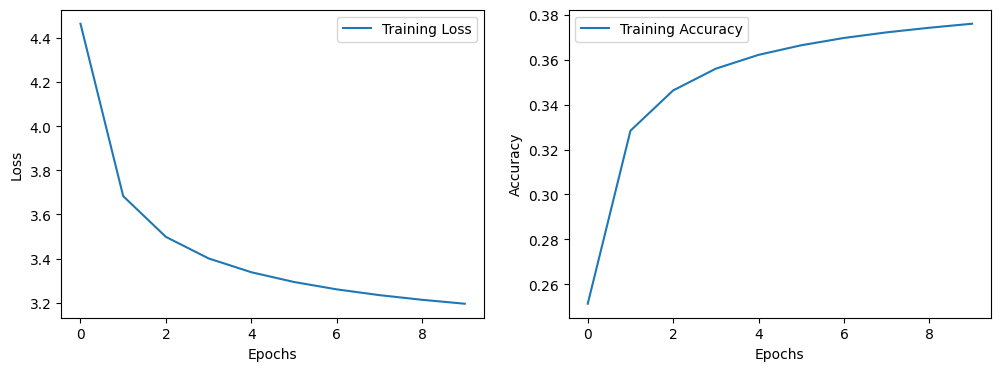

In [74]:
criterion = nn.CrossEntropyLoss().to(config.device)
optimizer = optim.Adam(model.parameters(), lr=config.lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer = optimizer,
    epochs = config.epochs,
    steps_per_epoch = datasets.__len__(),
    max_lr = config.lr,
    anneal_strategy = 'cos'
)

n_epochs = config.epochs
train_losses = []
train_accuracies = []

best_loss = float("inf")

for epoch in range(n_epochs):
    model.train() 
    states = [
        torch.zeros(n_layers, config.batch_size, hidden_dim).to(config.device),
        torch.zeros(n_layers, config.batch_size, hidden_dim).to(config.device)
    ]
    
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for i in range(0, datasets.size(1) - seq_length, seq_length):
        inputs = datasets[:, i:i + seq_length].to(config.device)
        targets = datasets[:, (i + 1):(i + 1 + seq_length)].to(config.device)

        states = detach(states)
        outputs, states = model(inputs, states)

        loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 計算準確率
        _, predicted = torch.max(outputs.view(-1, vocab_size), 1)
        correct_predictions += (predicted == targets.view(-1)).sum().item()
        total_predictions += targets.numel()  # Total elements in targets

        total_loss += loss.item()

    # 計算訓練損失
    train_loss = total_loss / ((datasets.size(1) - seq_length) // seq_length)
    train_accuracy = correct_predictions / total_predictions  

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy * 100:.2f}%")

    if train_loss < best_loss:
        save_file = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
            "epoch": epoch,
            "args": config
        }
        best_loss = train_loss
        torch.save(save_file, "checkpoint.pth")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

損失值設定為訓練損失的平均值，其值在訓練過程中不斷下降，從一開始的4.46，到最後大概落在3.2左右，而訓練資料準確率不斷上升，從一開始25.14%，到訓練結束為37.6%。

# (b) Use test.txt as input to your RNN model and calculate its accuracy. (5%)

## Testing

In [75]:
seed_everything(config.seed)
test_file_path = os.path.join(config.root, 'test.txt')
corpus_test = Corpus()
test_vector = corpus_test.get_data(test_file_path, batch_size=config.batch_size)

In [76]:
def calculate_accuracy(model, test_vector, seq_length):
    model.eval()
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        state = (torch.zeros(n_layers, 32, hidden_dim).to(config.device),
                 torch.zeros(n_layers, 32, hidden_dim).to(config.device))
        
        for i in range(0, test_vector.size(1) - seq_length, seq_length):
            inputs = test_vector[:, i:i + seq_length].to(config.device)
            targets = test_vector[:, (i + 1):(i + 1 + seq_length)].to(config.device)

            outputs, state = model(inputs, state)
            predictions = outputs.argmax(dim=1) 
           
            # Accumulate correct predictions
            correct_preds += (predictions == targets.view(-1)).sum().item()
            total_preds += targets.numel()  # Count total elements in targets

    accuracy = correct_preds / total_preds if total_preds > 0 else 0
    return accuracy

# Calculate and print accuracy
accuracy = calculate_accuracy(model, datasets, seq_length)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 37.72%


In [77]:
def calculate_perplexity(model, test_vector, seq_length):
    model.eval()
    total_log_prob = 0
    total_tokens = 0
    
    with torch.no_grad():
        state = (torch.zeros(n_layers, 32, hidden_dim).to(config.device),
                 torch.zeros(n_layers, 32, hidden_dim).to(config.device))
        for i in range(0, test_vector.size(1) - seq_length, seq_length):
            inputs = test_vector[:, i:i + seq_length].to(config.device)
            targets = test_vector[:, (i + 1):(i + 1 + seq_length)].to(config.device)
            
            outputs, state = model(inputs, state)

           # Reshape outputs for calculating probabilities
            if len(outputs.size()) == 2:  # If the model returns 2D output
                outputs = outputs.unsqueeze(1)  # Add sequence length dimension
            batch_size, _, vocab_size = outputs.size()  # Now should be [batch_size, seq_length, vocab_size]
            outputs = outputs.view(-1, vocab_size)

            # Get the log probabilities of the target tokens
            log_probs = F.log_softmax(outputs, dim=1)  # Apply log softmax
            log_probs = log_probs.gather(1, targets.view(-1, 1))  # Select the log probs of the target tokens
            
            total_log_prob += log_probs.sum().item()  # Sum log probabilities
            total_tokens += targets.numel()  # Count total tokens

            # Detach hidden state to avoid backpropagation through the entire history
            state = (state[0].detach(), state[1].detach())

    avg_log_prob = total_log_prob / total_tokens
    perplexity = 2 ** (-avg_log_prob / np.log(2))
    return perplexity

perplexity = calculate_perplexity(model, test_vector, seq_length)
print(f"Perplexity: {perplexity:.2f}")

Perplexity: 12970.38


# (c) Please use the test sentences from incomplete.txt to evaluate the model. This test set contains some incomplete sentences. Use the trained RNN model to complete the sentences (to reach a length of 20 words). (5%)

In [78]:
def complete_sentences(filename, rnn_model, vocab, seq_length=9, max_length=20, device='cpu'):
    with open(filename, 'r') as file:
        sentences = [line.strip() for line in file] 

    rnn_model.to(device)
    rnn_model.eval()  

    completed_sentences = []

    with torch.no_grad():
        for sentence in sentences:
            # 移除標點符號
            sentence = re.sub(r'[^\w\s]', '', sentence).lower()  
            # 把單字轉成對應的index
            indices = [vocab[word] for word in sentence.split() if word in vocab]

            # 啟動hidden與cell state
            state = (torch.zeros(rnn_model.n_layers, 1, rnn_model.lstm.hidden_size).to(device),
                     torch.zeros(rnn_model.n_layers, 1, rnn_model.lstm.hidden_size).to(device))

            # 產生字
            while len(indices) < max_length:
                input_tensor = torch.tensor([indices[-seq_length:]], dtype=torch.long).to(device)  # Use last `seq_length` tokens

                # 在模型中往前傳遞
                logits, state = rnn_model(input_tensor, state)
                
                # 根據最後一個時間點來得到預測字的index
                predicted_index = torch.argmax(F.softmax(logits[-1], dim=-1)).item()
                
                # 如果預測出的字或index沒有在字庫時就停止
                if predicted_index == vocab.get(None) or predicted_index not in vocab.values():
                    break

                indices.append(predicted_index)

            completed_sentence = " ".join([word for idx in indices for word, word_idx in vocab.items() if word_idx == idx])
            completed_sentences.append(completed_sentence.strip())  # Remove extra spaces

    for i, sentence in enumerate(completed_sentences):
        print(f"Completed Sentence {i + 1}: {sentence}")      

In [79]:
filename = "/kaggle/input/llm-hw1-dataset/incomplete.txt"
complete_sentences(
    filename = filename,
    rnn_model= model,
    vocab = corpus.dictionary.word2idx,
    seq_length = seq_length,
    max_length=20, device=config.device)

Completed Sentence 1: cover with a spatula <eos> add the chicken and cook for another 5 minutes <eos> add the chicken and cook
Completed Sentence 2: roll up <eos> add the chicken and cook for another 5 minutes <eos> add the chicken and cook for another
Completed Sentence 3: cook the chicken rice noodles in a large pot of boiling water <eos> add the chicken and cook for another
Completed Sentence 4: stir in a large bowl <eos> add the chicken and cook for another 5 minutes <eos> add the chicken and
Completed Sentence 5: spread out of the oven on the rack <eos> add the chicken and cook for another 5 minutes <eos> add
Completed Sentence 6: transfer the chicken to a plate <eos> add the chicken and cook for another 5 minutes <eos> add the chicken
Completed Sentence 7: put the top of the cake in the center <eos> add the chicken and cook for another 5 minutes <eos>
Completed Sentence 8: push the dough can be a little bit of the liquid <eos> add the chicken and cook for another 5
Completed Sent

因為要產生上限為20個字的句子，所以沒有限制預測出「eos」(end of sentence)就要停止，觀察這些句子，大致上還符合動詞加上名詞文法規則，但是語意上不如Trigram模型來得有道理，可能和模型訓練表現有關。

# 3. Analyze and compare the differences between n-gram model and RNN model, including the hardware resources required for their operations, the computation time taken for training, and the results of perplexity and accuracy. (10%)

1. 硬體資源上：n-gram模型會需要大量的記憶體來儲存訓練資料裡的n-gram，計算上則是較為簡單，只要計數與計算條件機率。RNN模型則是需要儲存權重與梯度，然後在計算上比n-grama模型複雜，會有矩陣運算與線性轉換，所以會需要GPU才有辦法在一定時間內執行完畢。
2. 運算時間上：n-gram模型所需要的訓練時間較短，但計算準確率就會花比較多時間，Bigram與Trigram模型都大概需要一個半小時。RNN模型因為有正向與反向傳播的關係，所需要的訓練時間會比較長，大約需要兩個小時左右才有辦法訓練完畢，但是計算準確率就會比較快。
3. 困惑度(Perplexity)與準確率(Accuracy)：n-gram模型的困惑度在詞組比較短的時候會比較低，但如果詞組長度增加，表現就會開始變差，而準確率則是大概落在25%上下。RNN模型的困惑度為12970.38，準確率為37.72%，較n-gram模型來得好。